# Evaluate Model Performance

TODO convert this to test.py

In [1]:
import os
import pprint
from tqdm import tqdm
import torch
import torch.nn as nn

from data_loader.cityscapes import CityscapesDataLoader
from model.deeplabv3plus import DeepLabv3Plus
from model.metric import SegmentationMetrics

import torchvision.transforms as transforms
import utils.transforms
from utils.visualize import get_palette, color_mask
import matplotlib.pyplot as plt

%matplotlib inline

## Get DataLoader

In [2]:
img_root = "./data/leftImg8bit"
mask_root = "./data/gtFine"
batch_size = 4

cityscapes = CityscapesDataLoader(img_root, mask_root, batch_size)

## Load Model

In [3]:
run = "run2"
checkpoint_file = os.path.join("experiments", "checkpoints", run, "best_model.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = cityscapes.train_set.num_classes  # 0 -> 19
ignore_idx = cityscapes.train_set.ignoreId  # ignore 19
learning_rate = 0.001
model = DeepLabv3Plus(num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=ignore_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

## Get mIoU

In [4]:
def evaluate_performance(
    model, data_loader, criterion, num_classes, ignore_idx, device
):
    model.eval()

    total_loss = 0
    metrics = SegmentationMetrics(num_classes=num_classes, ignore_idx=ignore_idx)
    with torch.no_grad():
        for i, sample in enumerate(tqdm(data_loader)):
            images = sample["image"].to(device)
            masks = sample["mask"].to(device)

            pred = model(images)
            loss = criterion(pred, masks)
            total_loss += loss.item()

            pred_cls = torch.argmax(pred, dim=1)
            metrics.update(pred_cls, masks)

    ious, mIoU = metrics.iou()
    return total_loss, ious, mIoU


loss, ious, mIoU = evaluate_performance(
    model, cityscapes.val_loader, criterion, num_classes, ignore_idx, device
)

100%|██████████| 125/125 [01:43<00:00,  1.21it/s]


In [5]:
iou_per_class = {
    cityscapes.val_set.trainId_to_name[i]: iou for i, iou in enumerate(ious)
}
pprint.pprint(iou_per_class)
print(f"mIoU: {mIoU}")

{'bicycle': 0.1265816906967565,
 'building': 0.5206117344842304,
 'bus': 0.04445289374687464,
 'car': 0.3330635251404821,
 'fence': 0.02679877407778894,
 'motorcycle': 0.0,
 'person': 0.042404947018104995,
 'pole': 0.15760380544286026,
 'rider': 0.014851765131720339,
 'road': 0.730912291387783,
 'sidewalk': 0.35325403095556734,
 'sky': 0.5840919463371359,
 'terrain': 0.08026863908529805,
 'traffic light': 0.03664315046856902,
 'traffic sign': 0.13098087128574767,
 'train': 0.006704719841299547,
 'truck': 0.06718353518384446,
 'unlabeled': 0.0,
 'vegetation': 0.5387457814810035,
 'wall': 0.06286918220434728}
mIoU: 0.20305385705102177


## Plot Predictions

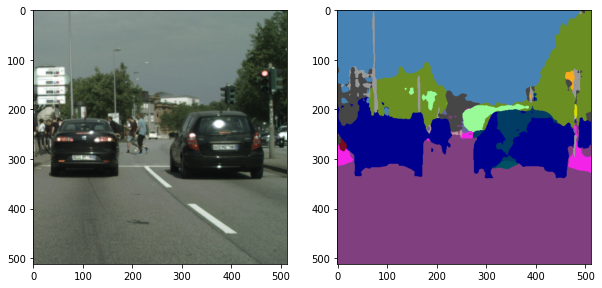

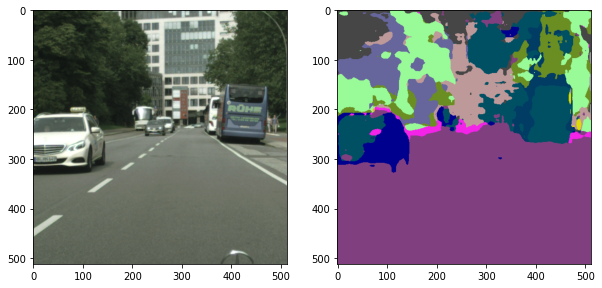

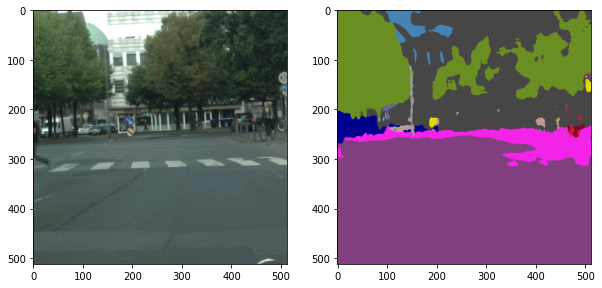

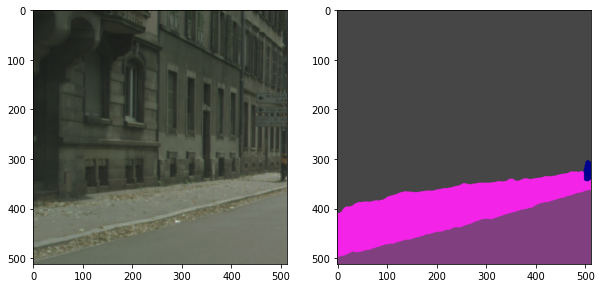

In [6]:
def plot_predictions(model, data_loader, n_batches, device):
    model.eval()
    toPIL = transforms.ToPILImage()
    resize = utils.transforms.Resize((1024, 2048))
    palette = get_palette()
    
    for i, sample in enumerate(data_loader):
        if i == n_batches:
            break
        
        with torch.no_grad():
            images, masks = sample["image"].to(device), sample["mask"].to(device)

            pred = model(images)
            pred = torch.argmax(pred, dim=1).cpu().detach()

            for i in range(len(images)):
                image, mask = images[i], pred[i]
                image = toPIL(image)

                mask = color_mask(mask.numpy(), palette)
                fig, ax = plt.subplots(1, 2, figsize=(10, 10))
                ax[0].imshow(image)
                ax[1].imshow(mask)
                plt.show()


plot_predictions(model, cityscapes.train_loader, 1, device)